In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
warnings.filterwarnings("ignore")
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

- baseline보다 data columns 더 사용
- epoch늘림
- 50 -> 30개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용

In [28]:
%%time
def trainGenerator():
    
    train_path = 'data/train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:14]
        
        if (cutoff_labels > 0).sum() < 25:
            
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,14]),tf.TensorShape([40,40,1])))
train_dataset = train_dataset.batch(512).prefetch(1)

Wall time: 13 ms


In [29]:
train_dataset

<DatasetV1Adapter shapes: ((None, 40, 40, 14), (None, 40, 40, 1)), types: (tf.float32, tf.float32)>

In [23]:
%%time
test_path = 'data/test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    
    data = np.load(file)
    
    X_test.append(data[:,:,:])
                  
X_test = np.array(X_test)

test: 100%|██████████████████████████████████████████████████████████████████████| 2416/2416 [00:01<00:00, 1988.94it/s]


Wall time: 1.45 s


In [24]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load('data/train/subset_010462_01.npy')

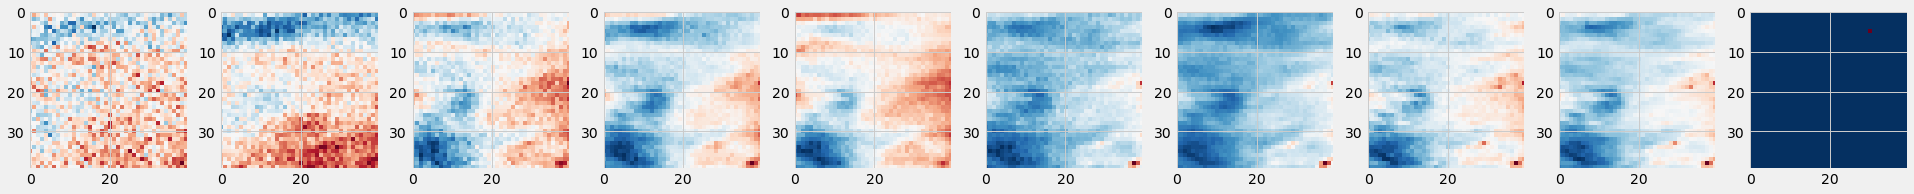

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [25]:
def build_model(input_layer, start_neurons):
    
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

   
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)


    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 14))
output_layer = build_model(input_layer, 32)
model = Model(input_layer, output_layer)

In [26]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [31]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])
model_history = model.fit(train_dataset, epochs = 7, verbose=1)

Epoch 1/7
77/77 [==============================] - 527s 7s/step - loss: 0.2919 - maeOverFscore_keras: 7.9553 - fscore_keras: 0.3425
Epoch 2/7
77/77 [==============================] - 538s 7s/step - loss: 0.2408 - maeOverFscore_keras: 3.6942 - fscore_keras: 0.4967
Epoch 3/7
77/77 [==============================] - 566s 7s/step - loss: 0.2315 - maeOverFscore_keras: 3.2634 - fscore_keras: 0.5377
Epoch 4/7
77/77 [==============================] - 559s 7s/step - loss: 0.2237 - maeOverFscore_keras: 2.9873 - fscore_keras: 0.5669
Epoch 5/7
77/77 [==============================] - 556s 7s/step - loss: 0.2199 - maeOverFscore_keras: 2.8398 - fscore_keras: 0.5853
Epoch 6/7
77/77 [==============================] - 590s 8s/step - loss: 0.2188 - maeOverFscore_keras: 2.8074 - fscore_keras: 0.5873
Epoch 7/7
77/77 [==============================] - 630s 8s/step - loss: 0.2159 - maeOverFscore_keras: 2.7263 - fscore_keras: 0.5978


In [ ]:
model_history = model.fit(train_dataset, epochs = 1, verbose=1)

     19/Unknown - 141s 7s/step - loss: 0.2154 - maeOverFscore_keras: 2.5308 - fscore_keras: 0.6289

In [35]:
pred = model.predict(X_test)
submission = pd.read_csv('data/sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('Dacon_baseline1.csv', index = False)